# Debugging backwards NaN bug

January 2022

gully


We get NaNs in the backward pass after 3 steps.  Why?

In [1]:
%config Completer.use_jedi = False

In [2]:
import torch
from blase.emulator import PhoenixEmulator, SparsePhoenixEmulator
import matplotlib.pyplot as plt
from gollum.phoenix import PHOENIXSpectrum
import numpy as np
from tqdm.notebook import tqdm
import os
import copy

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
device

'cpu'

### Make a tensor composed of $N_{lines}$ sparsely spaced spectral lines.

I have experimentally verified that this notebook works with up to 500,000 lines.  You may wish to turn off overplotting all the lines for $N_{lines}>500$.  Also, the amplitudes become unphysical and the spectrum can become negative because we are adding flux loss and not opacity.

In [4]:
spectrum = PHOENIXSpectrum(teff=4100, logg=3.5)#, wl_lo=8019, wl_hi=12845)
spectrum = spectrum.divide_by_blackbody()
spectrum = spectrum.normalize()
continuum_fit = spectrum.fit_continuum(polyorder=5)
spectrum = spectrum.divide(continuum_fit, handle_meta="ff")

In [5]:
# Numpy arrays: 1 x N_pix
wl_native = spectrum.wavelength.value
flux_native = spectrum.flux.value

In [6]:
emulator = SparsePhoenixEmulator(wl_native, flux_native, prominence=0.01)

Initializing a sparse model with 11759 spectral lines


In [7]:
emulator.to(device)

SparsePhoenixEmulator()

In [8]:
state_dict_init = copy.deepcopy(emulator.state_dict())

In [9]:
state_dict_init['lam_centers'].shape

torch.Size([11759])

In [10]:
state_dict_post = torch.load('../examples/sparse_T4100g3p5_prom0p01_HPF.pt')

In [11]:
emulator.load_state_dict(state_dict_post)

<All keys matched successfully>

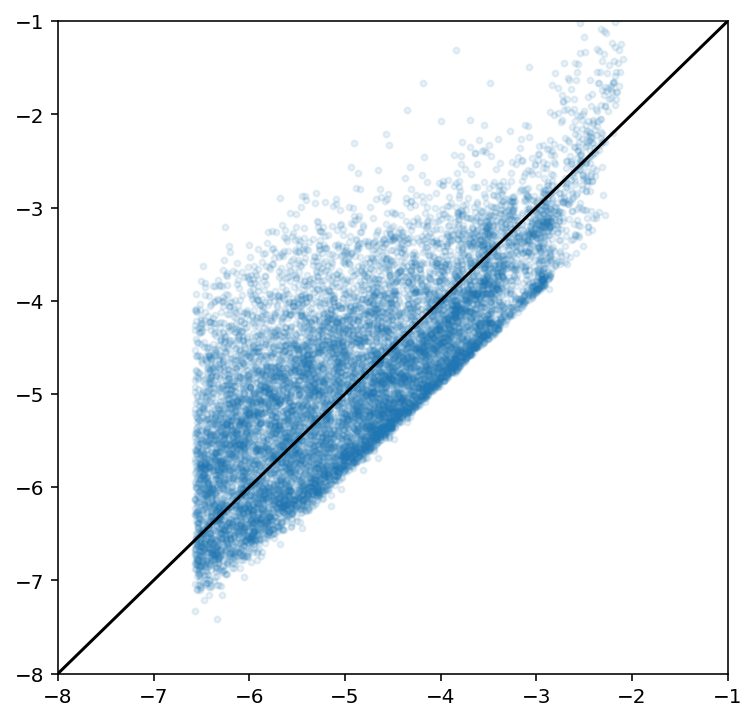

In [18]:
plt.figure(figsize=(6,6))
plt.plot(state_dict_init['amplitudes'].numpy(), state_dict_post['amplitudes'].numpy(), '.', alpha=0.1)
plt.plot(np.arange(-8, 0), np.arange(-8, 0), color='k')
plt.xlim(-8, -1)
plt.ylim(-8, -1);

In [19]:
%%time
with torch.no_grad():
    spec_out = emulator.forward().cpu().numpy()

CPU times: user 1.82 s, sys: 1.12 s, total: 2.94 s
Wall time: 619 ms


## Read in real data

In [13]:
from muler.hpf import HPFSpectrum

In [14]:
dir = '~/GitHub/star-witness/data/HPF/goldilocks/UT21-3-015/'
dir = os.path.expanduser(dir)
fn = 'Goldilocks_20210919T084302_v1.0_0063.spectra.fits'
raw_data = HPFSpectrum(file=dir+fn, order=5)

In [15]:
data = raw_data.sky_subtract().deblaze().normalize().trim_edges((8,2040))

In [16]:
#data.plot(ylo=0)

In [17]:
wl = emulator.wl_native[emulator.active_mask].numpy()
flux = emulator.flux_native[emulator.active_mask].numpy()

In [18]:
from blase.emulator import EchelleModel

In [19]:
model = EchelleModel(data.spectral_axis.bin_edges.value, emulator.wl_native)

In [20]:
model.to(device)

EchelleModel()

Convert HPF resolution in FWHM to $\sigma$:

In [21]:
n_lines = len(emulator.amplitudes)

In [22]:
state_dict_perturbed = torch.load("../experiments/02_synthetic_injection/model_T4100g3p5_prom0p01_HPF_perturbedAmp.pt")

In [25]:
state_dict_init

OrderedDict([('amplitudes',
              tensor([-2.8509, -6.0667, -4.7868,  ..., -4.8431, -5.5356, -4.5948],
                     dtype=torch.float64)),
             ('sigma_widths',
              tensor([-3.4681, -3.1693, -3.3344,  ..., -3.3792, -3.3796, -3.3587],
                     dtype=torch.float64)),
             ('gamma_widths',
              tensor([-3.2962, -2.9975, -3.1626,  ..., -3.2073, -3.2077, -3.1868],
                     dtype=torch.float64)),
             ('lam_centers',
              tensor([ 8068.2300,  8068.5100,  8068.6600,  ..., 12817.4200, 12818.4200,
                      12818.9000], dtype=torch.float64)),
             ('a_coeff', tensor(1., dtype=torch.float64)),
             ('b_coeff', tensor(0., dtype=torch.float64)),
             ('c_coeff', tensor(0., dtype=torch.float64)),
             ('radial_velocity', tensor(0.0050, dtype=torch.float64))])

In [23]:
fake_sigma_angs = torch.tensor(0.09)
fake_vsini = torch.tensor(3.9)

with torch.no_grad():
    rotationally_broadened = model.rotational_broaden(emulator.forward(), fake_vsini)
    instrumeanally_broadened = model.instrumental_broaden(rotationally_broadened, fake_sigma_angs)
    noisefree_signal = model.resample_to_data(instrumeanally_broadened)

In [24]:
synthetic_spectrum = torch.load('../experiments/02_synthetic_injection/synthetic_perturbed_spectrum.pt')

(0.0, 1.0)

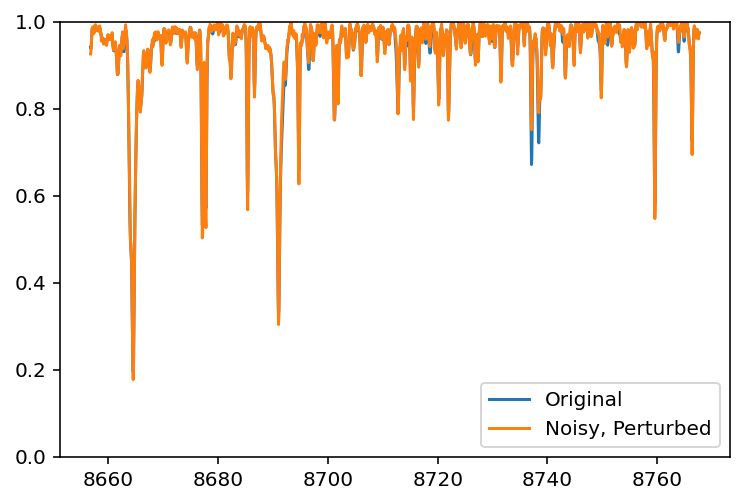

In [25]:
plt.plot(data.wavelength, noisefree_signal, label='Original');
plt.plot(data.wavelength, synthetic_spectrum, label='Noisy, Perturbed');
plt.legend(loc='lower right')
plt.ylim(0, 1)

Ok, let's try a few steps and see what happens.

## Step by step optimize

In [26]:
import torch.optim as optim

In [27]:
from torch import nn

In [28]:
data_target = synthetic_spectrum

In [29]:
loss_fn = nn.MSELoss(reduction="mean")

In [30]:
emulator.radial_velocity.requires_grad = False
emulator.gamma_widths.requires_grad = False
emulator.lam_centers.requires_grad = False
emulator.sigma_widths.requires_grad = False

In [31]:
optimizer = optim.Adam(
    list(filter(lambda p: p.requires_grad, model.parameters()))
    + list(filter(lambda p: p.requires_grad, emulator.parameters())),
    0.01,
    amsgrad=True,
)

losses = []

In [47]:
model.train()
emulator.train()
high_res_model = emulator.forward()
yhat = model.forward(high_res_model)
loss = loss_fn(yhat, data_target)
loss.backward()
optimizer.step()
for name, param in model.named_parameters():
    print(name, param.grad)
for name, param in emulator.named_parameters():
    print(name, param.grad)
optimizer.zero_grad()
losses.append(loss.item())
print(loss.item())

ln_sigma_angs tensor(1.8089e-05, dtype=torch.float64)
ln_vsini tensor(0.0014, dtype=torch.float64)
amplitudes tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64)
sigma_widths None
gamma_widths None
lam_centers None
a_coeff None
b_coeff None
c_coeff None
radial_velocity None
0.001446569175487887


In [33]:
model.ln_sigma_angs

Parameter containing:
tensor(-2.3100, dtype=torch.float64, requires_grad=True)

In [34]:
model.ln_vsini

Parameter containing:
tensor(2.8800, dtype=torch.float64, requires_grad=True)

In [35]:
torch.all(emulator.amplitudes == state_dict_init['amplitudes'])

tensor(True)

In [36]:
mask = emulator.amplitudes == state_dict_init['amplitudes']

In [37]:
emulator.amplitudes[~mask]

tensor([], dtype=torch.float64, grad_fn=<IndexBackward>)

In [38]:
high_res_model

tensor([1., 1., 1.,  ..., 1., 1., 1.], dtype=torch.float64,
       grad_fn=<ExpBackward>)

In [39]:
with torch.no_grad():
    mask = high_res_model!=high_res_model
mask.sum()

tensor(0)

In [40]:
wls = emulator.wl_native[mask]

In [41]:
np.nanmin(high_res_model.detach().numpy())

0.04675941634228156

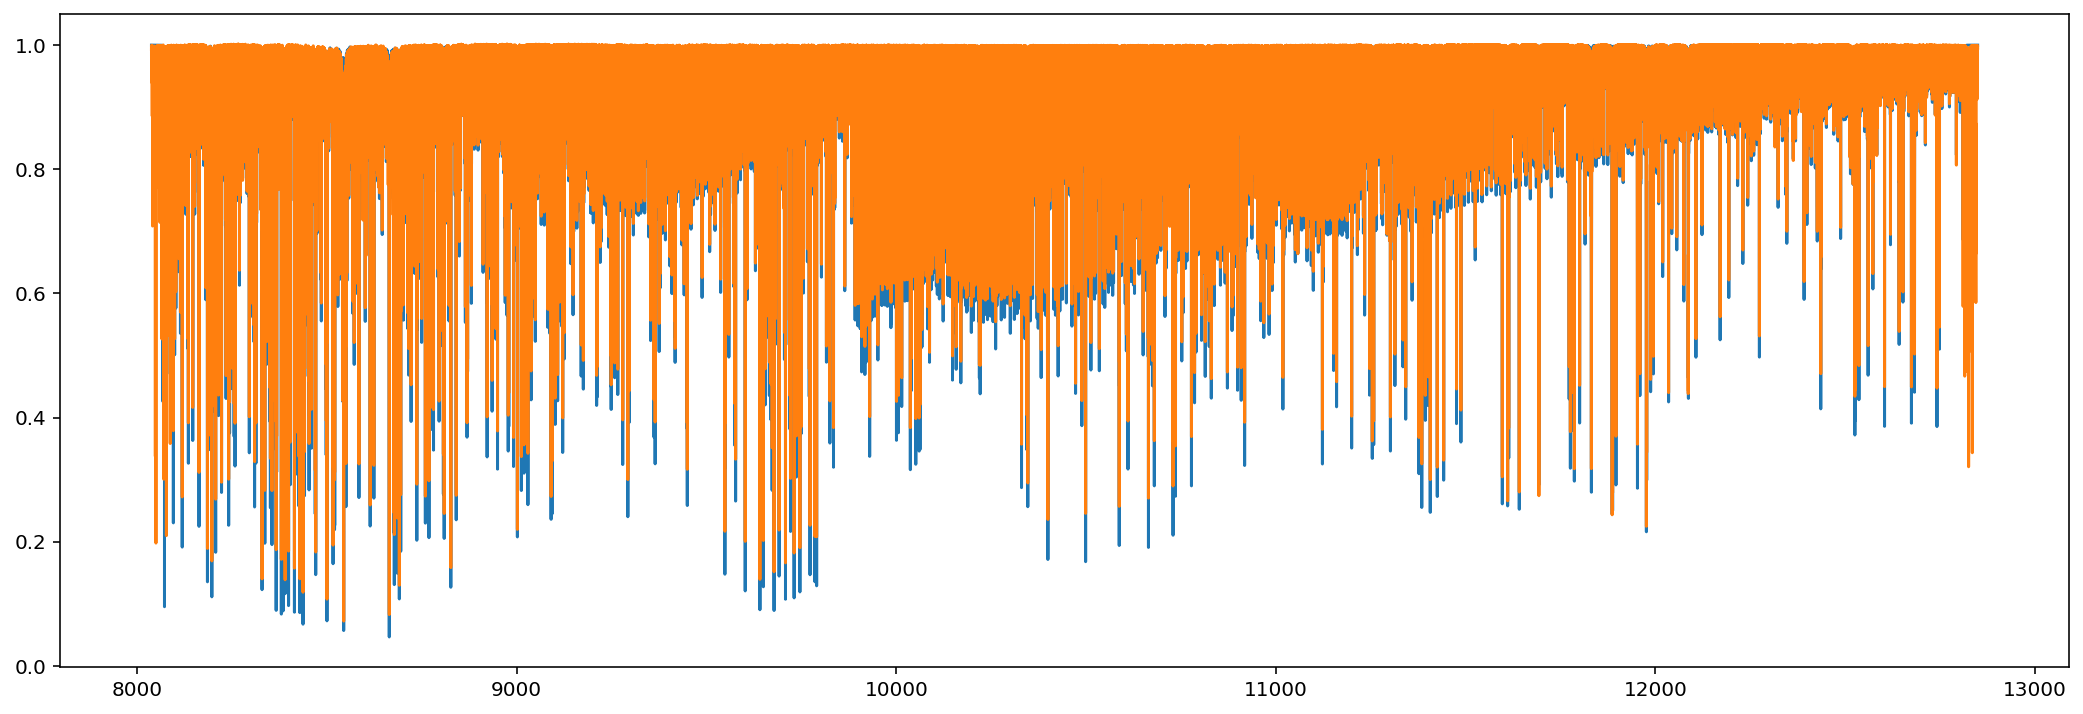

In [43]:
plt.figure(figsize=(18, 6))
plt.plot(emulator.wl_native, high_res_model.detach())
plt.plot(emulator.wl_native, emulator.flux_native)
#for wl in wls:
#    plt.axvline(wl, color='r', linestyle='dotted', alpha=0.3)
#plt.xlim(wls.min()-10, wls.max()+10)

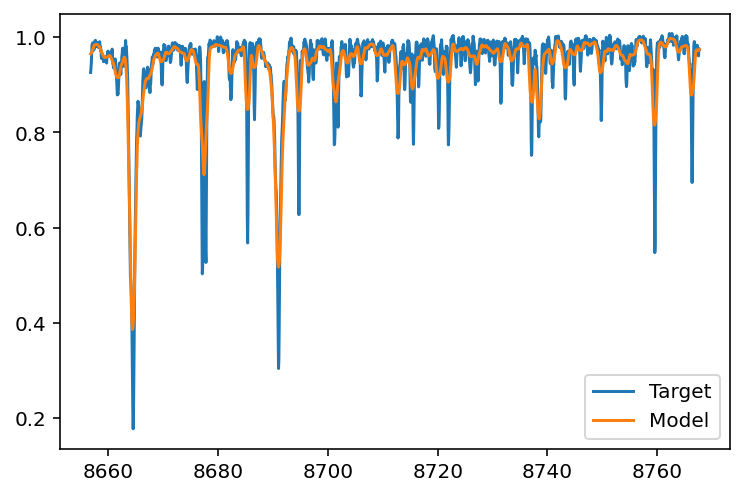

In [44]:
with torch.no_grad():
    plt.plot(data.wavelength.value, data_target.numpy(), label='Target')
    plt.plot(data.wavelength.value, yhat.detach().numpy(), label='Model')
    plt.legend()

In [30]:
roi_mask = ((state_dict_init['lam_centers'].numpy() > data.wavelength.value.min()) &
            (state_dict_init['lam_centers'].numpy() < data.wavelength.value.max()) )

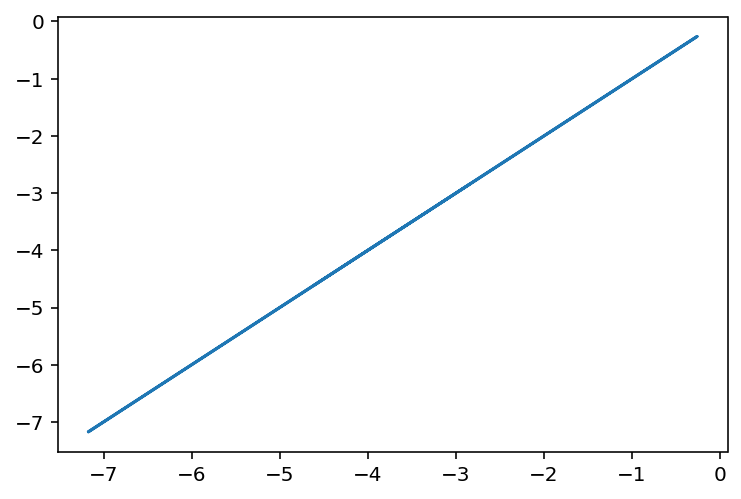

In [36]:
with torch.no_grad():
    plt.plot(state_dict_post['amplitudes'].numpy(), emulator.amplitudes.detach())
    #plt.plot(state_dict_post['amplitudes'].numpy(), state_dict_perturbed['amplitudes'], '.', alpha=0.01)
    #plt.plot(state_dict_post['amplitudes'].numpy()[roi_mask], 
    #         state_dict_perturbed['amplitudes'].numpy()[roi_mask], '*', alpha=1, color='k')
